In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import argparse
import json
import pickle
import torch

from pyfolio import timeseries
import pyfolio
import finrl.config as config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer,data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
#from finrl.preprocessing.data import data_split
#from finrl.env.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
#from finrl.model.models import DRLAgent
#from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
#import train_config

import sys
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)
def get_train_data(train_config):
    df = pd.read_csv(train_config.train_file)
    df = df.set_index("Unnamed: 0")
    # process data: add covariance matrix
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    cov_list = []
    lookback=252 # look back is one year
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values 
        cov_list.append(covs)
    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    return df
# MAIN EXPERIMENT
def experiment(train_config):
    if_nlp = train_config["IF_NLP"]
    ticker_list = train_config["TICKER_LIST"]
    start = train_config["START_DATE"]
    end = train_config["END_DATE"]
    train_test = train_config["TRAIN_TEST_SPLIT"]
    model_name = train_config["MODEL_NAME"]
    indicators = train_config["INDICATORS"]
    model_direct = train_config["MODEL_DIRECT"]
    data_direct = train_config["DATA_DIRECT"]
    # Download data
    df = YahooDownloader(start_date = start,
                        end_date = end,
                        ticker_list = ticker_list).fetch_data()
    #df = pd.read_excel(data_direct+"/"+train_config["PRICE_FILE"], engine='openpyxl')
    #df = df.sort_values(['date','tic']).reset_index(drop=True)
    # process data: add tech_indicators
    fe = FeatureEngineer(
                        use_technical_indicator=True,
                        use_turbulence=False,
                        user_defined_feature = False)
    df = fe.preprocess_data(df)
    # process data: add covariance matrix
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    #df.to_csv(f'{data_direct}/{start}_{end}_nlp{if_nlp}.csv',index=False)
    cov_list = []
    lookback=train_config["LOOKBACK"] # look back is one year
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values 
        cov_list.append(covs)
    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
    df = df.merge(df_cov, on='date')
    if if_nlp:
        nlp = pd.read_csv(f'{data_direct}/{train_config["NLP_FILE"]}')
        columns = ['date','tic']
        columns.extend(train_config["NLP_INDICATORS"])
        indicators.extend(train_config["NLP_INDICATORS"])
        nlp = nlp[columns]
        df = df.merge(nlp,on=["date","tic"],how='left')
        df.fillna(0,inplace=True)
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    # split data
    #pd.to_datetime("2022-12-07")
    train = data_split(df, start, train_test)
    trade = data_split(df, train_test, end)
    #train = data_split(df, pd.to_datetime(start), pd.to_datetime(train_test))
    #trade = data_split(df, pd.to_datetime(train_test), pd.to_datetime(end))
    # prepare portfolioEnv
    stock_dimension = len(train.tic.unique())
    state_space = stock_dimension
    #print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    env_kwargs = {
        "hmax": train_config["HMAX"], 
        "initial_amount": train_config["INITIAL_AMOUNT"], 
        "transaction_cost_pct": train_config["TRANSACTION_COST"], 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": indicators, 
        "action_space": stock_dimension, 
        "reward_scaling": train_config["REWARD_SCALING"]
        
    }
    e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
    env_train, _ = e_train_gym.get_sb_env()

    #trade = data_split(df,'2019-01-01', '2020-01-01')
    e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

    # initialize
    agent = DRLAgent(env = env_train)
    agent = DRLAgent(env = env_train)
    SAC_PARAMS = train_config["PARAMS"]

    model_sac = agent.get_model(model_name,model_kwargs = SAC_PARAMS)
    trained_sac = agent.train_model(model=model_sac, 
                                tb_log_name=model_name,
                                total_timesteps=train_config["T"])
    df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)
    return df_daily_return, df_actions, trained_sac
    df_daily_return.to_csv(f'{train_config["RESULT_DIRECT"]}/daily_return.csv')
    df_actions.to_csv(f'{train_config["RESULT_DIRECT"]}/daily_action.csv')
    torch.save(trained_sac,
            f'{model_direct}/{model_name.upper()}_nlp{if_nlp}.pt' # TODO how to save model in a better way
        )
    #torch.save(trained_sac,
    #        f'{model_name.upper()}_nlp{if_nlp}.pt' # TODO how to save model in a better way
    #    )
    # create an iterator object with write permission - model.pkl
    #with open(f'{model_direct}/{model_name.upper()}_nlp{if_nlp}.pkl', 'wb') as files:
    #    pickle.dump(trained_sac, files)
    return trained_sac

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# EXAMINE RESULTS
def check_portfolio(daily_return):
    DRL_strat = convert_daily_return_to_pyfolio_ts(daily_return)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
    print("==============DRL Strategy Stats===========")
    print(perf_stats_all)
    return DRL_strat, perf_stats_all
def graph_portfolio(DRL_strat, base, start, end):
  baseline_df = get_baseline(
        ticker=base, start=start, end=end
    )
  baseline_returns = get_daily_return(baseline_df, value_col_name="close")
  with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)
    

# Experiments

In [3]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)

## Baseline Model: RL

In [4]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
base_return, base_action, base_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)



Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2672990.1316880607
Sharpe:  1.8259847284356108
begin_total_asset:1000000
end_total_asset:3827954.9622335327
Sharpe:  2.1514948528387734
begin_total_asset:1000000
end_total_asset:3827954.9622335327
Sharpe:  2.1514948528387734
begin_total_asset:1000000
end_total_asset:3827954.9622335327
Sharpe:  2.1514948528387734
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 97        |
|    time_elapsed    | 14        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -4.24e+06 |
|    critic_loss     | 3.58e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 3827955.0 |
----------------------------------
begin_total_asset:1000000
end_total_asse

==============DRL Strategy Stats===========
Annual return          0.152660
Cumulative returns     0.153310
Annual volatility      0.405608
Sharpe ratio           0.552105
Calmar ratio           0.385224
Stability              0.009966
Max drawdown          -0.396289
Omega ratio            1.098082
Sortino ratio          0.817931
Skew                   0.105648
Kurtosis               1.691428
Tail ratio             1.207084
Daily value at risk   -0.050213
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


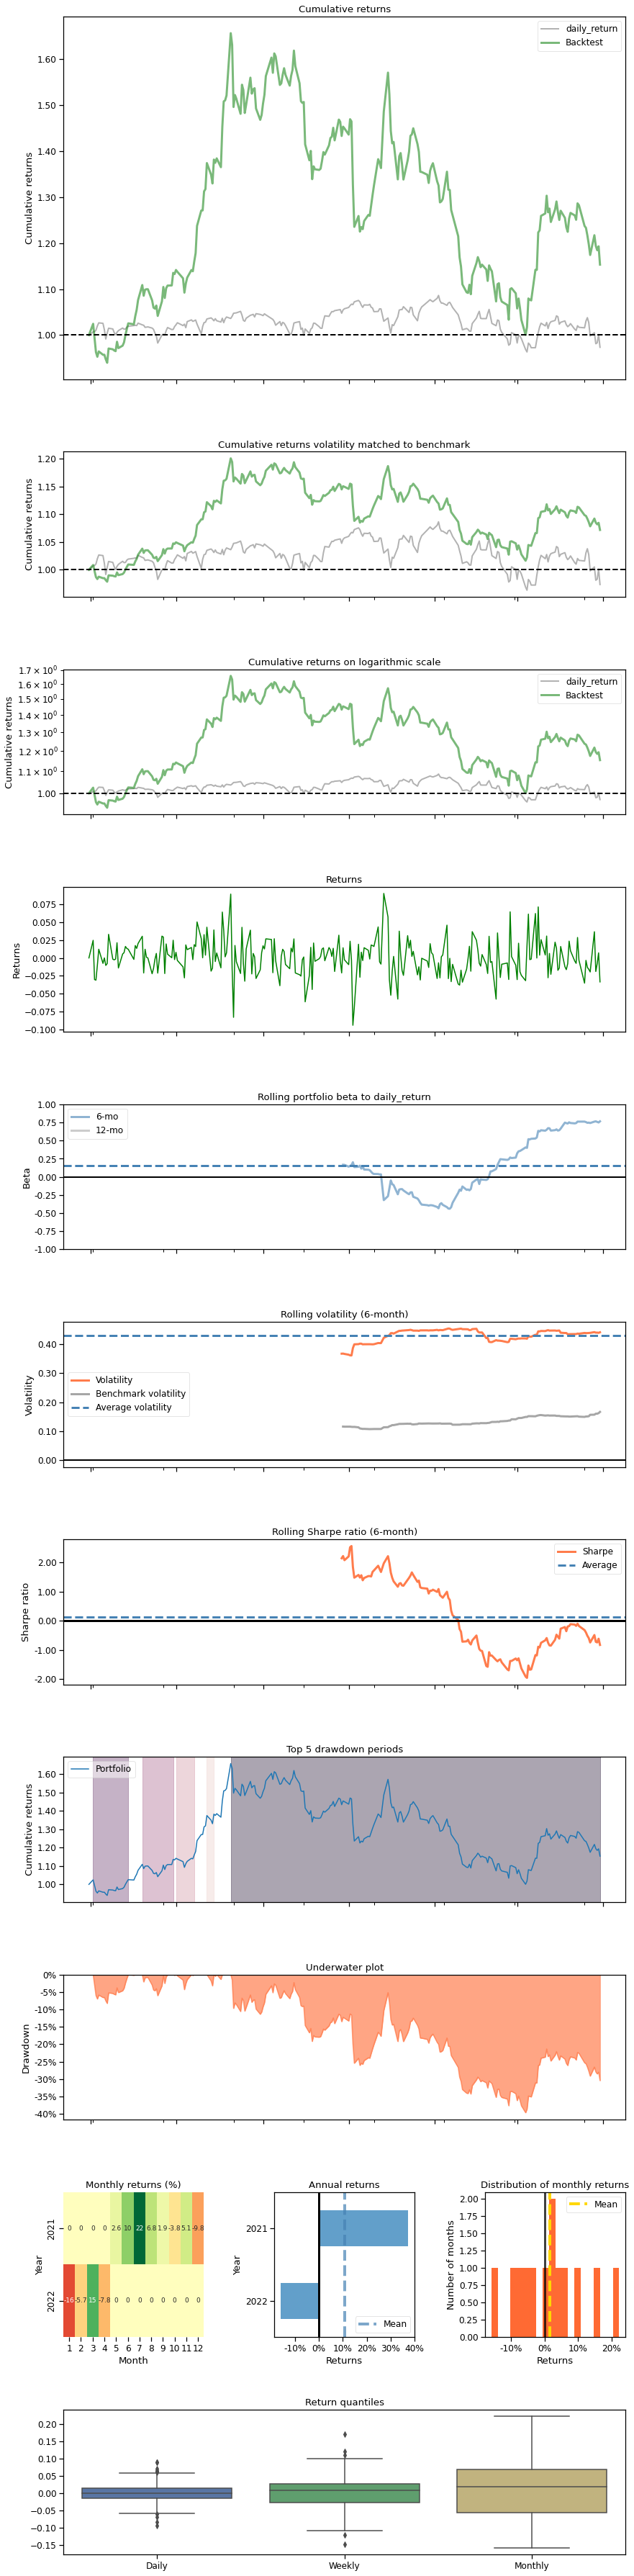

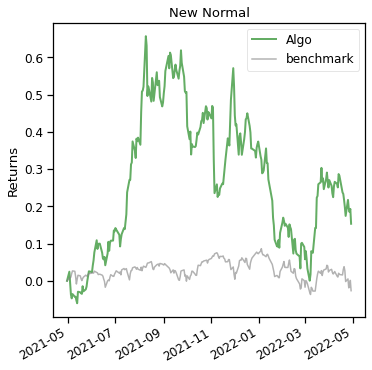

In [6]:
%matplotlib inline
base_strat, base_stats = check_portfolio(base_return)
graph_portfolio(base_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

## Experiment 1: RL + NLP(4 scores)

In [7]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
exp1_return, exp1_action, exp1_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)



Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2483410.529376584
Sharpe:  1.7233528113187597
begin_total_asset:1000000
end_total_asset:2962530.8062644443
Sharpe:  2.0485723439088157
begin_total_asset:1000000
end_total_asset:2962530.8062644443
Sharpe:  2.0485723439088157
begin_total_asset:1000000
end_total_asset:2962530.8062644443
Sharpe:  2.0485723439088157
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 105       |
|    time_elapsed    | 13        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.92e+06 |
|    critic_loss     | 1.72e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 2962530.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset

==============DRL Strategy Stats===========
Annual return          0.206898
Cumulative returns     0.207799
Annual volatility      0.339440
Sharpe ratio           0.722835
Calmar ratio           0.680106
Stability              0.111572
Max drawdown          -0.304215
Omega ratio            1.129759
Sortino ratio          1.086067
Skew                   0.179974
Kurtosis               1.788072
Tail ratio             1.123625
Daily value at risk   -0.041792
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


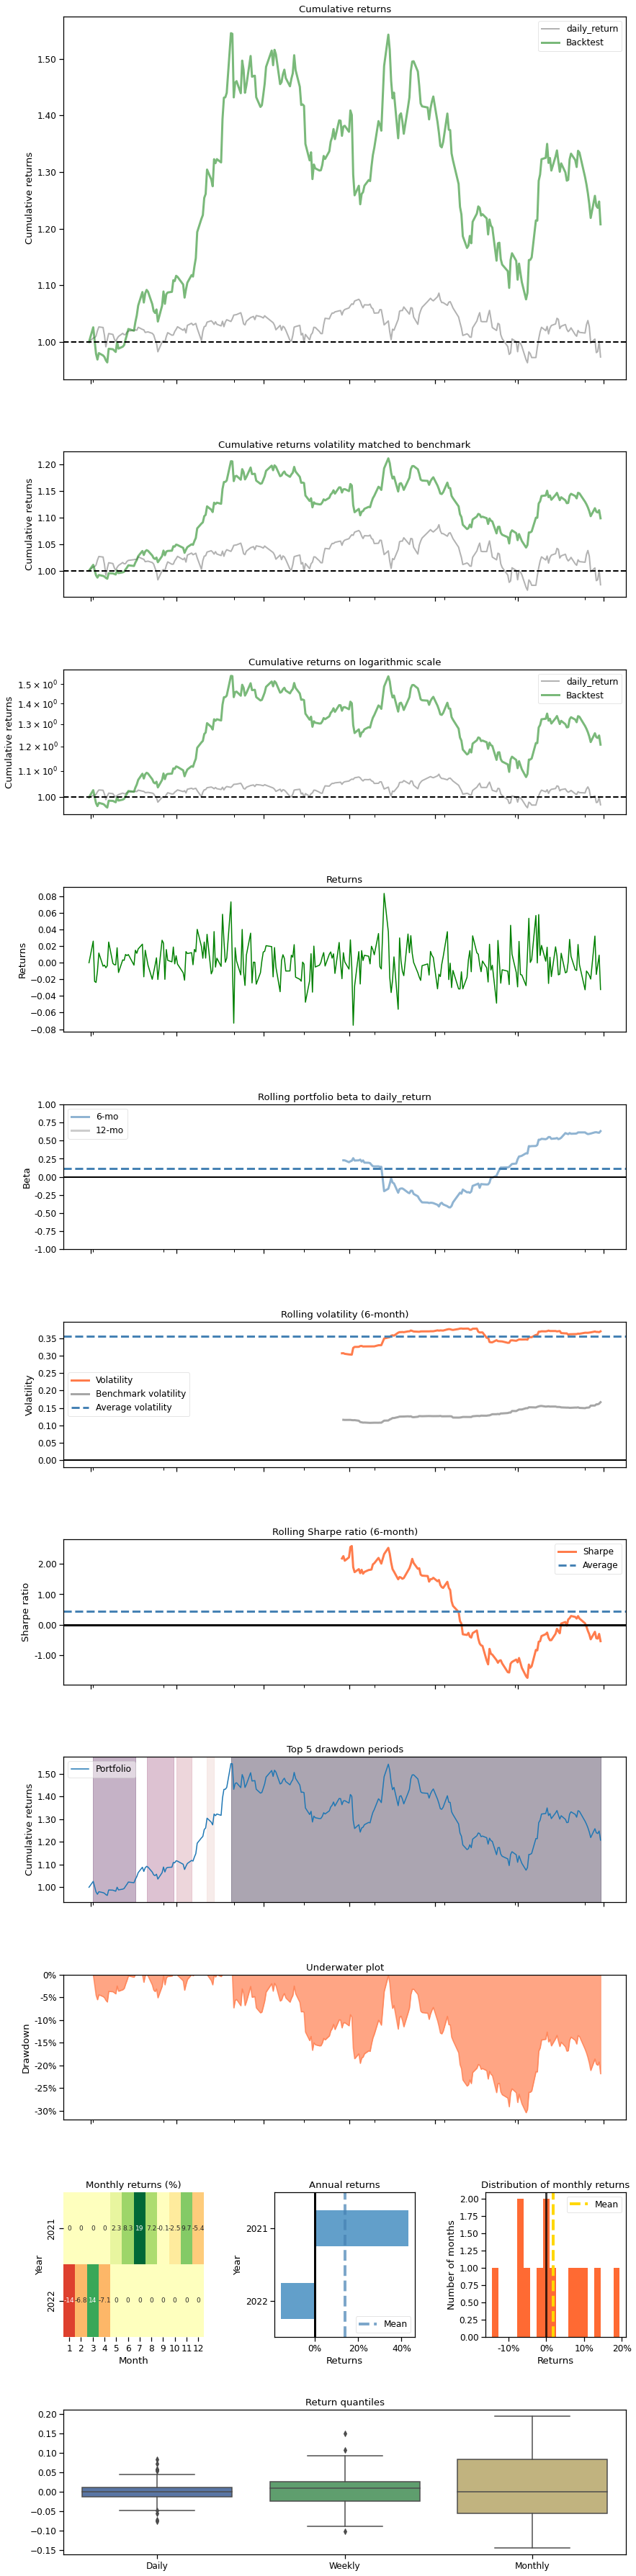

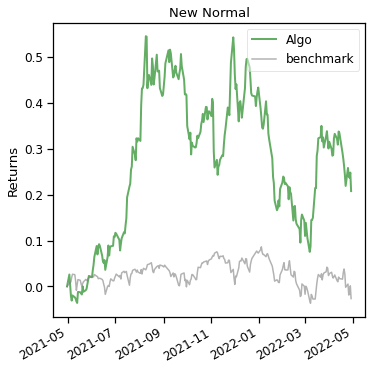

In [8]:
%matplotlib inline
exp1_strat, exp1_stats = check_portfolio(exp1_return)
graph_portfolio(exp1_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

## Experiment 2: RL + NLP(Afinn)

In [9]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_afinn"]#,"weighted_positive","weighted_negative","weighted_neutral"]
exp2_return, exp2_action, exp2_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2777614.027996385
Sharpe:  1.877932491621426
begin_total_asset:1000000
end_total_asset:3015270.7238213336
Sharpe:  2.1059511176194285
begin_total_asset:1000000
end_total_asset:3015270.7238213336
Sharpe:  2.1059511176194285
begin_total_asset:1000000
end_total_asset:3015270.7238213336
Sharpe:  2.1059511176194285
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 85        |
|    time_elapsed    | 16        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.99e+06 |
|    critic_loss     | 1.83e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 3015270.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:

==============DRL Strategy Stats===========
Annual return          0.166937
Cumulative returns     0.167652
Annual volatility      0.317322
Sharpe ratio           0.644543
Calmar ratio           0.533391
Stability              0.033212
Max drawdown          -0.312973
Omega ratio            1.113672
Sortino ratio          0.954879
Skew                   0.073359
Kurtosis               1.489205
Tail ratio             1.094485
Daily value at risk   -0.039167
Alpha                  0.000000
Beta                   1.000000
dtype: float64


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


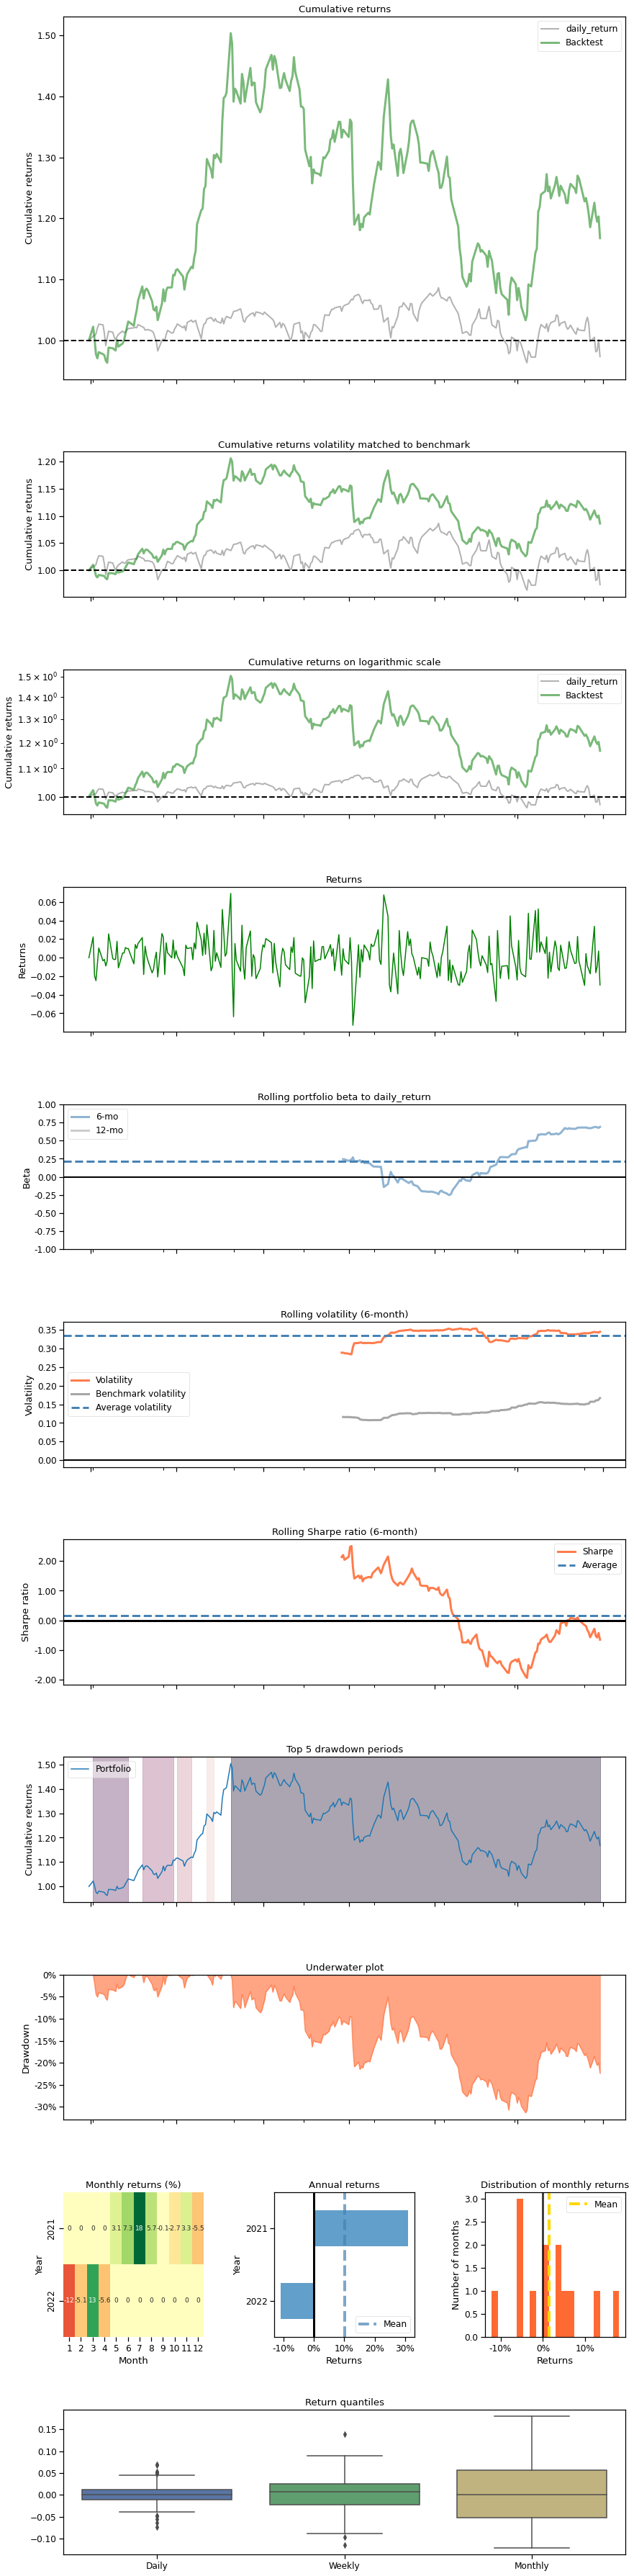

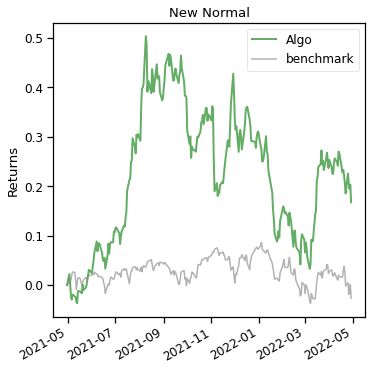

In [10]:
%matplotlib inline
exp2_strat, exp2_stats = check_portfolio(exp2_return)
graph_portfolio(exp2_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

In [11]:
exp2_action

JNJ      MRNA       PFE      ^TNX
date                                              
2021-04-30  0.250000  0.250000  0.250000  0.250000
2021-05-03  0.365529  0.365529  0.134471  0.134471
2021-05-04  0.365529  0.365529  0.134471  0.134471
2021-05-05  0.365529  0.365529  0.134471  0.134471
2021-05-06  0.365529  0.365529  0.134471  0.134471
...              ...       ...       ...       ...
2022-04-25  0.365529  0.365529  0.134471  0.134471
2022-04-26  0.365529  0.365529  0.134471  0.134471
2022-04-27  0.365529  0.365529  0.134471  0.134471
2022-04-28  0.365529  0.365529  0.134471  0.134471
2022-04-29  0.365529  0.365529  0.134471  0.134471

[253 rows x 4 columns]

In [12]:
df = pd.read_csv('./dataset/nlp.csv')
df.shape

(1129, 7)

In [13]:
1129-253

876

## Experiment 3: RL + NLP(positive, neutral, negative)

In [14]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_positive","weighted_negative","weighted_neutral"]
exp3_return, exp3_action, exp3_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will b

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2595071.2620127513
Sharpe:  1.8070365551870322
begin_total_asset:1000000
end_total_asset:3827955.1228065845
Sharpe:  2.151494898157526
begin_total_asset:1000000
end_total_asset:3827955.1228065845
Sharpe:  2.151494898157526
begin_total_asset:1000000
end_total_asset:3827955.1228065845
Sharpe:  2.151494898157526
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 92        |
|    time_elapsed    | 15        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -4.21e+06 |
|    critic_loss     | 3.6e+11   |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 3827955.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:3

==============DRL Strategy Stats===========
Annual return          0.152660
Cumulative returns     0.153310
Annual volatility      0.405608
Sharpe ratio           0.552105
Calmar ratio           0.385224
Stability              0.009966
Max drawdown          -0.396289
Omega ratio            1.098082
Sortino ratio          0.817931
Skew                   0.105648
Kurtosis               1.691428
Tail ratio             1.207083
Daily value at risk   -0.050213
Alpha                  0.000000
Beta                   1.000000
dtype: float64


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


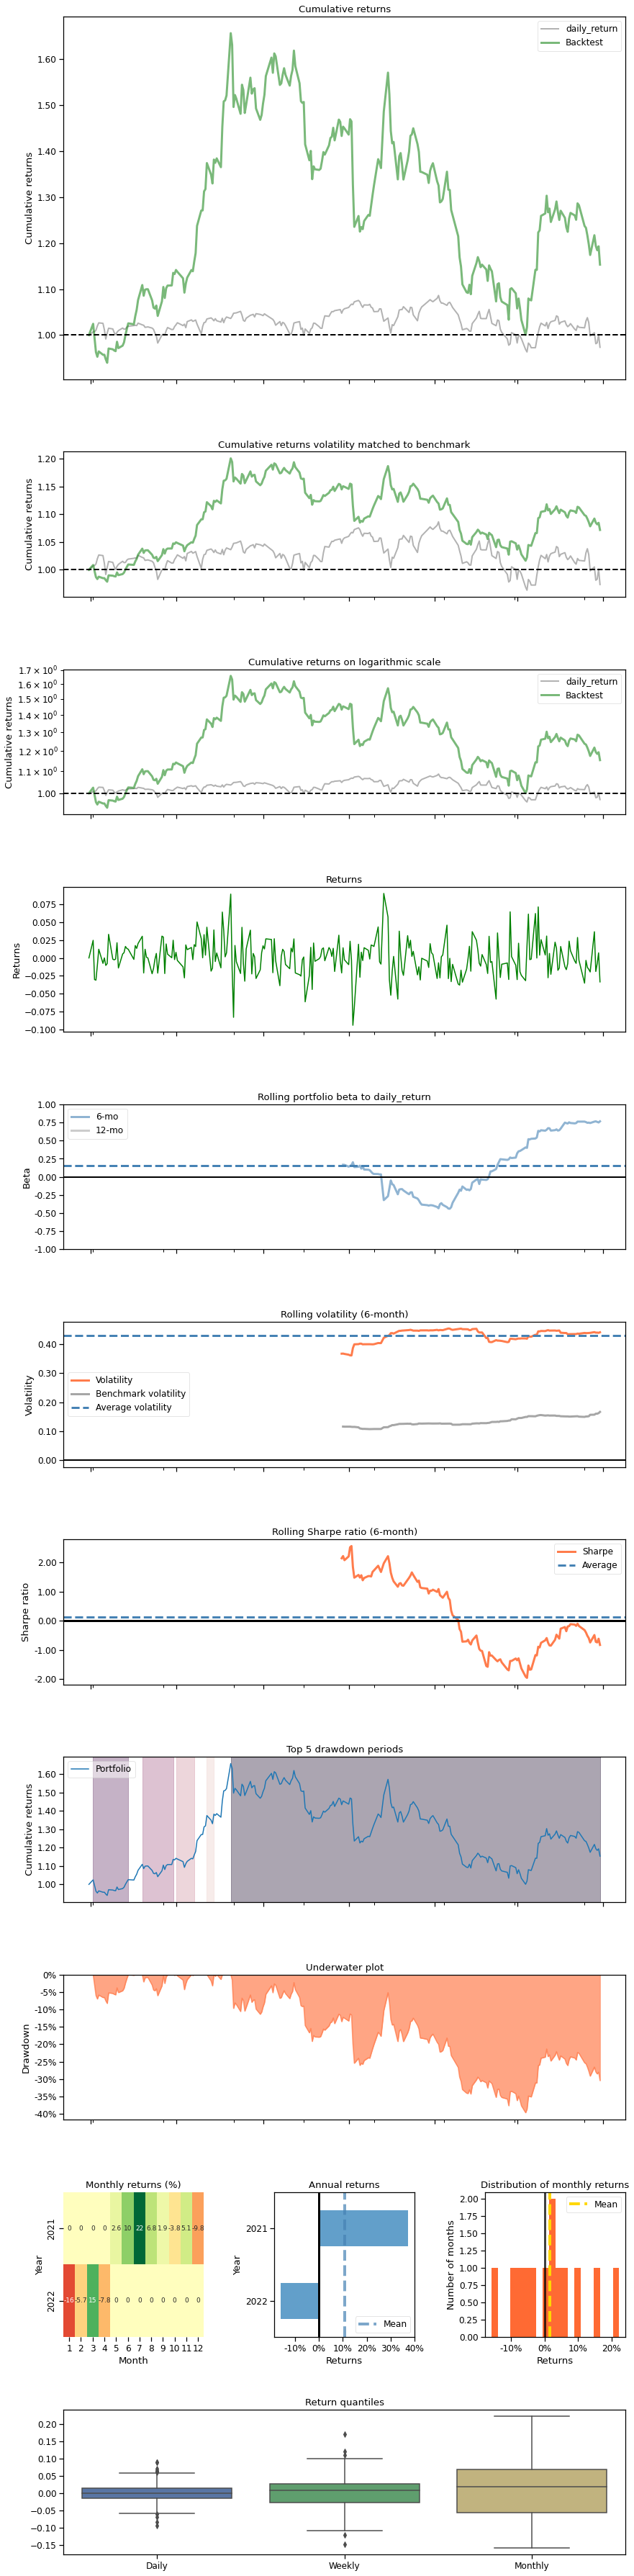

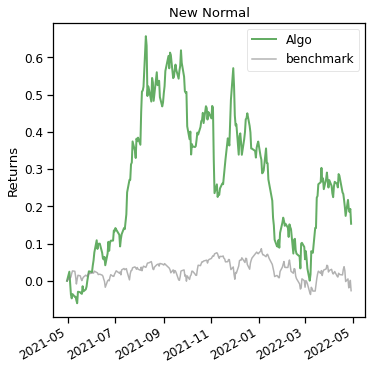

In [15]:
%matplotlib inline
exp3_strat, exp3_stats = check_portfolio(exp3_return)
graph_portfolio(exp3_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

## Experiment 4: RL + NLP(positive)

In [16]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_positive"]#,"weighted_negative","weighted_neutral"]
exp4_return, exp4_action, exp4_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will b

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2354634.7676514117
Sharpe:  1.6878232064804044
begin_total_asset:1000000
end_total_asset:2962530.8142717984
Sharpe:  2.0485723410798355
begin_total_asset:1000000
end_total_asset:2962530.8142717984
Sharpe:  2.0485723410798355
begin_total_asset:1000000
end_total_asset:2962530.8142717984
Sharpe:  2.0485723410798355
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 99        |
|    time_elapsed    | 14        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.87e+06 |
|    critic_loss     | 1.72e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 2962530.8 |
----------------------------------
begin_total_asset:1000000
end_total_asse

==============DRL Strategy Stats===========
Annual return          0.206898
Cumulative returns     0.207799
Annual volatility      0.339440
Sharpe ratio           0.722835
Calmar ratio           0.680106
Stability              0.111572
Max drawdown          -0.304215
Omega ratio            1.129759
Sortino ratio          1.086067
Skew                   0.179974
Kurtosis               1.788073
Tail ratio             1.123626
Daily value at risk   -0.041792
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


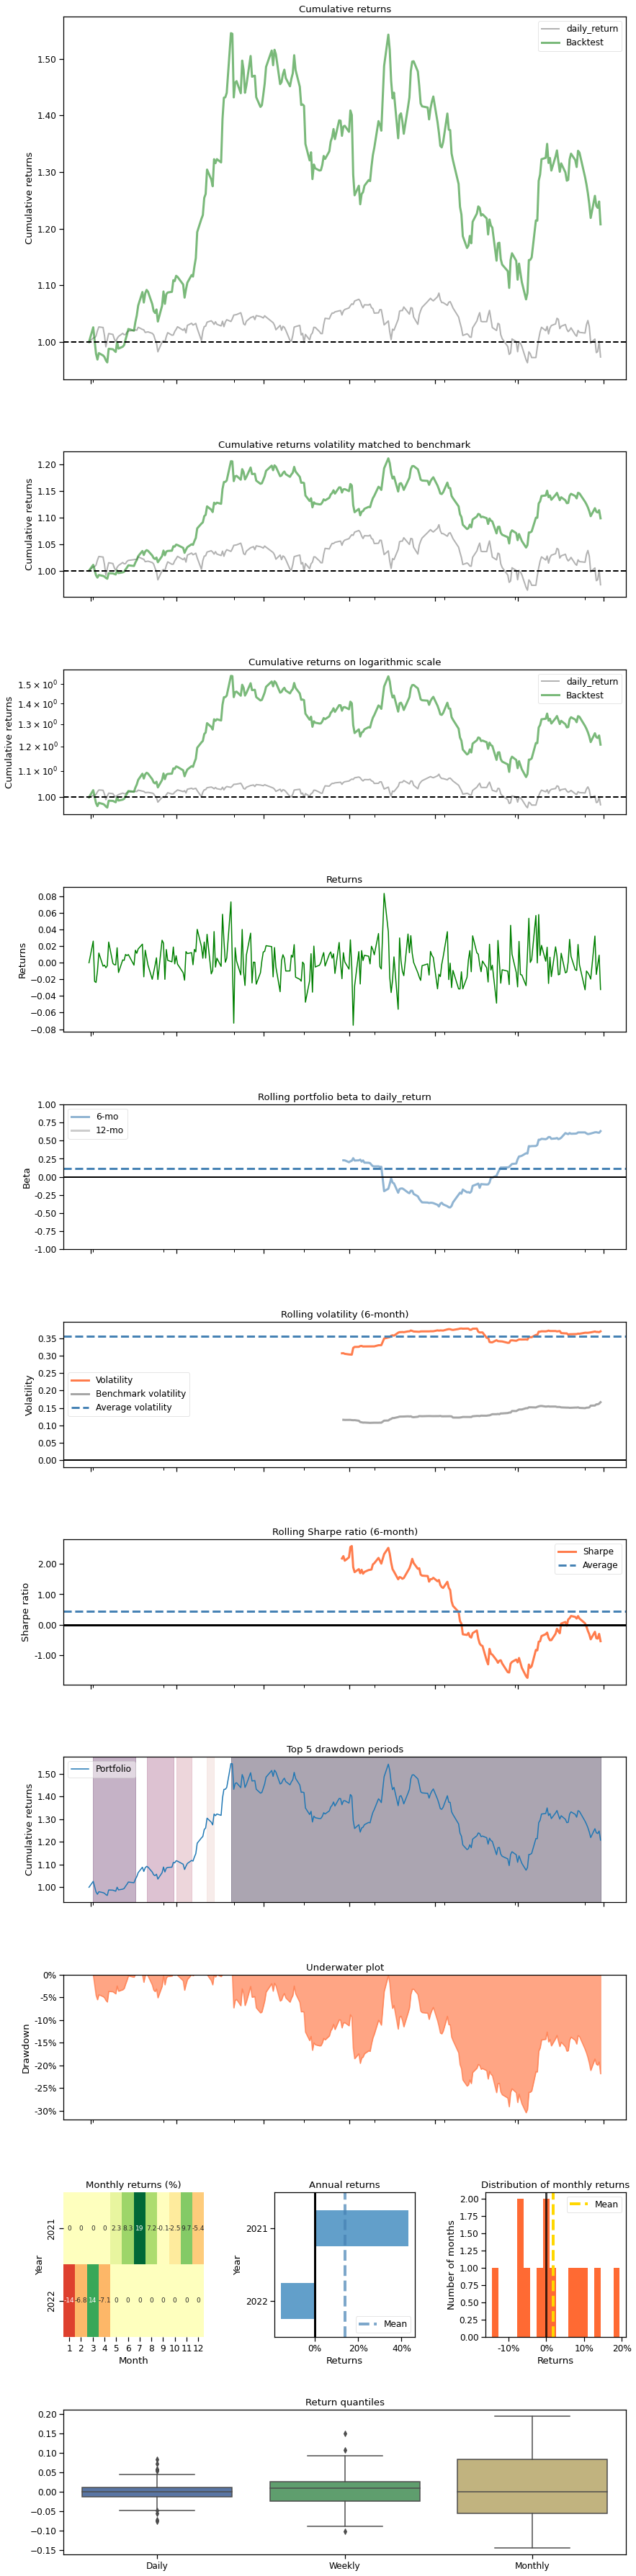

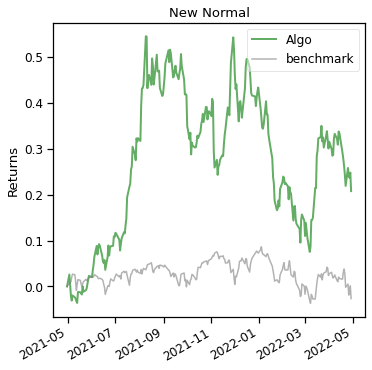

In [17]:
%matplotlib inline
exp4_strat, exp4_stats = check_portfolio(exp4_return)
graph_portfolio(exp4_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

## Experiemnt 5: RL + NLP(afinn, positiv)

In [18]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_afinn","weighted_positive"]#,"weighted_negative","weighted_neutral"]
exp5_return, exp5_action, exp5_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2190759.7649672832
Sharpe:  1.5460105340705277
begin_total_asset:1000000
end_total_asset:2616879.6728573698
Sharpe:  1.7412527391031034
begin_total_asset:1000000
end_total_asset:2616879.6728573698
Sharpe:  1.7412527391031034
begin_total_asset:1000000
end_total_asset:2616879.6728573698
Sharpe:  1.7412527391031034
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 90        |
|    time_elapsed    | 15        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.56e+06 |
|    critic_loss     | 1.17e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 2616879.8 |
----------------------------------
begin_total_asset:1000000
end_total_asse

==============DRL Strategy Stats===========
Annual return          0.290244
Cumulative returns     0.291549
Annual volatility      0.285525
Sharpe ratio           1.035206
Calmar ratio           1.372436
Stability              0.334837
Max drawdown          -0.211481
Omega ratio            1.187900
Sortino ratio          1.528139
Skew                  -0.082000
Kurtosis               1.153307
Tail ratio             1.174568
Daily value at risk   -0.034800
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


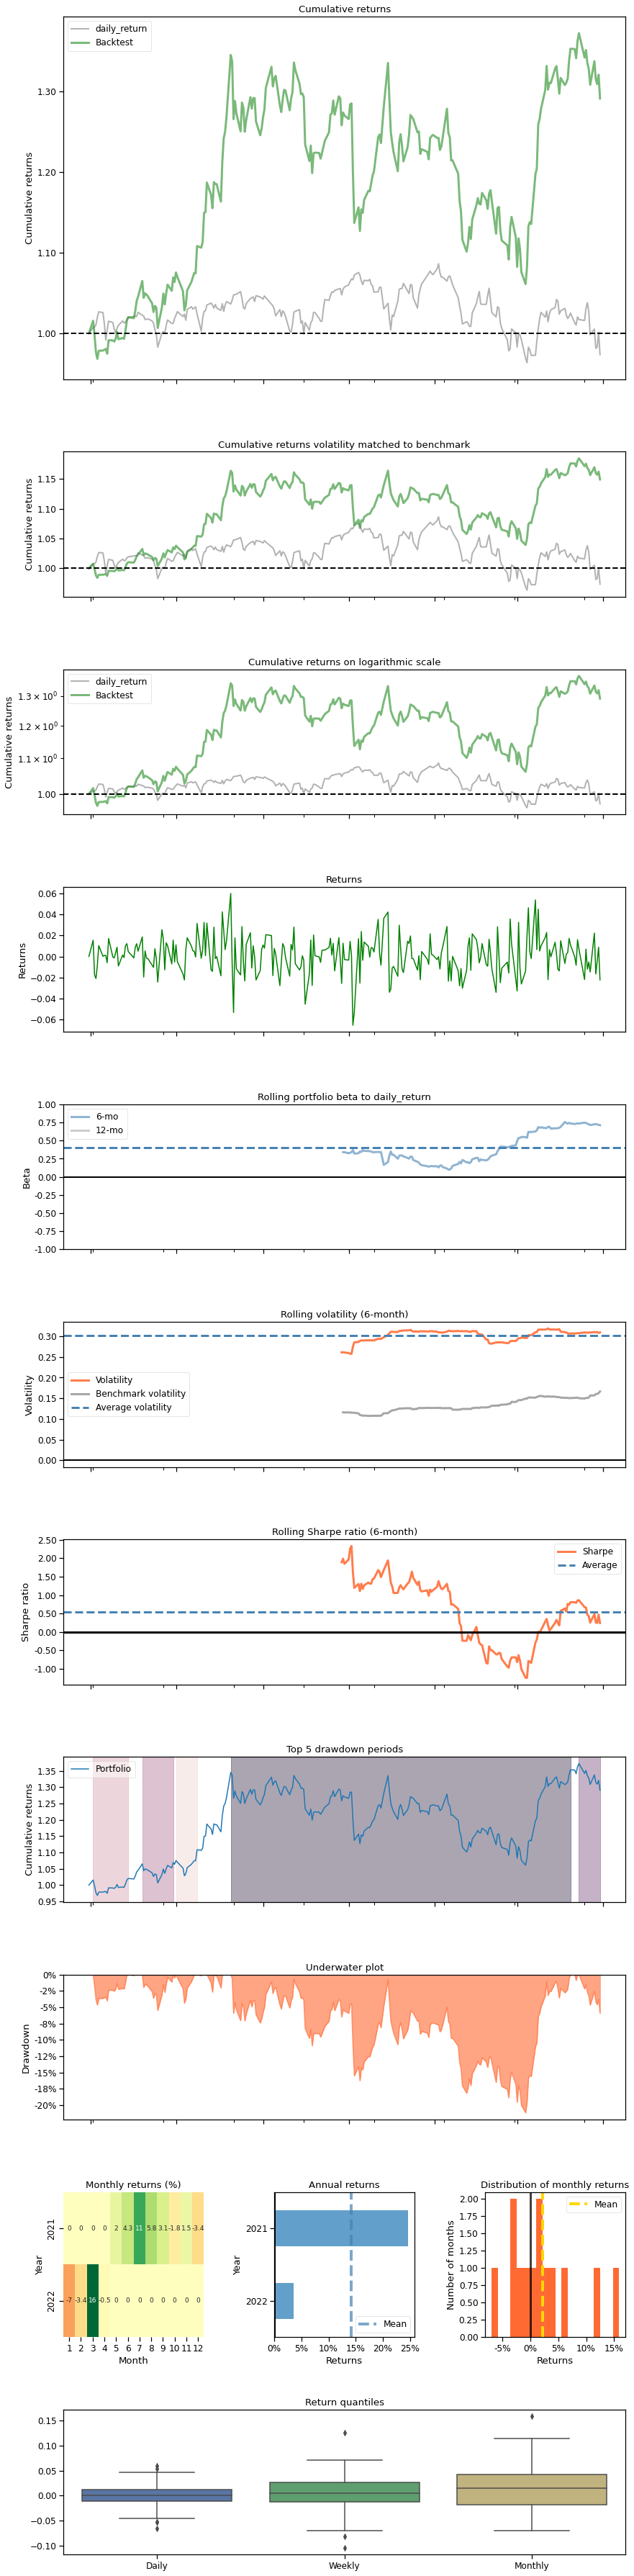

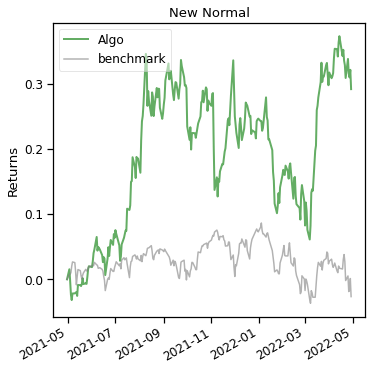

In [19]:
%matplotlib inline
exp5_strat, exp5_stats = check_portfolio(exp5_return)
graph_portfolio(exp5_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

In [23]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_negative"]#,"weighted_negative","weighted_neutral"]
exp6_return, exp6_action, exp6_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2123072.8385097813
Sharpe:  1.5565315665515382
begin_total_asset:1000000
end_total_asset:2542454.4256203375
Sharpe:  1.9914757804627081
begin_total_asset:1000000
end_total_asset:2542454.4256203375
Sharpe:  1.9914757804627081
begin_total_asset:1000000
end_total_asset:2542454.4256203375
Sharpe:  1.9914757804627081
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 81        |
|    time_elapsed    | 17        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.67e+06 |
|    critic_loss     | 1.16e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 2542454.5 |
----------------------------------
begin_total_asset:1000000
end_total_asse

==============DRL Strategy Stats===========
Annual return          0.204471
Cumulative returns     0.205360
Annual volatility      0.281806
Sharpe ratio           0.800450
Calmar ratio           0.820440
Stability              0.151237
Max drawdown          -0.249221
Omega ratio            1.142245
Sortino ratio          1.205772
Skew                   0.165613
Kurtosis               1.505163
Tail ratio             1.162462
Daily value at risk   -0.034609
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


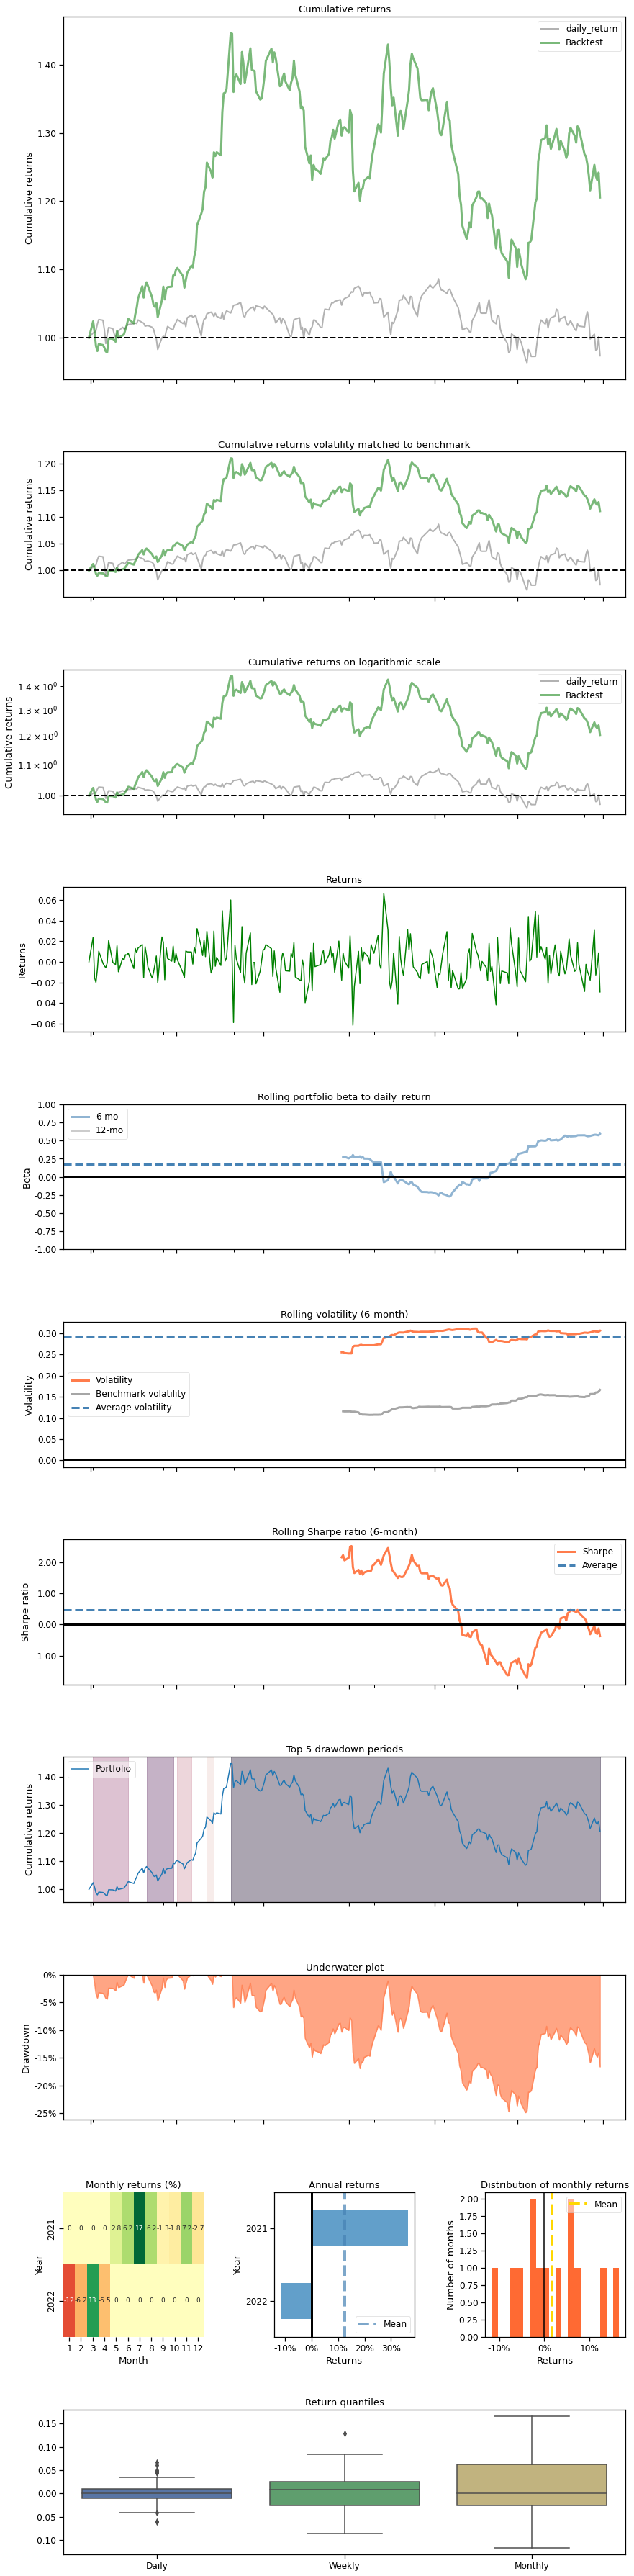

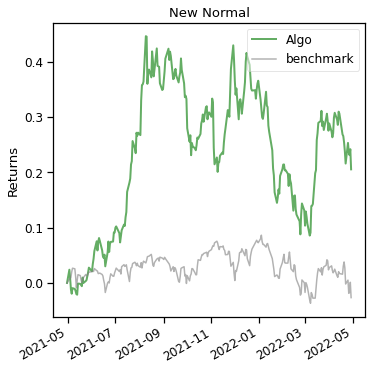

In [24]:
%matplotlib inline
exp6_strat, exp6_stats = check_portfolio(exp6_return)
graph_portfolio(exp6_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

In [37]:
with open('train_config.json', "r") as inp:
    train_config = json.load(inp)
train_config["IF_NLP"] = True
train_config["NLP_INDICATORS"]= ["weighted_afinn","weighted_positive","weighted_negative"]#,"weighted_neutral"]
exp7_return, exp7_action, exp7_model = experiment(train_config)

[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3420, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be

Successfully added technical indicators
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100}
Using cpu device
begin_total_asset:1000000
end_total_asset:2795483.687379659
Sharpe:  1.8356722675879054
begin_total_asset:1000000
end_total_asset:2542454.857098629
Sharpe:  1.99147653329095
begin_total_asset:1000000
end_total_asset:2542454.857098629
Sharpe:  1.99147653329095
begin_total_asset:1000000
end_total_asset:2542454.857098629
Sharpe:  1.99147653329095
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 85        |
|    time_elapsed    | 16        |
|    total_timesteps | 1400      |
| train/             |           |
|    actor_loss      | -3.75e+06 |
|    critic_loss     | 1.33e+11  |
|    learning_rate   | 0.0003    |
|    n_updates       | 1050      |
|    reward          | 2542454.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2542454.

==============DRL Strategy Stats===========
Annual return          0.204471
Cumulative returns     0.205360
Annual volatility      0.281805
Sharpe ratio           0.800450
Calmar ratio           0.820440
Stability              0.151237
Max drawdown          -0.249221
Omega ratio            1.142245
Sortino ratio          1.205772
Skew                   0.165612
Kurtosis               1.505162
Tail ratio             1.162461
Daily value at risk   -0.034609
Alpha                  0.000000
Beta                   1.000000
dtype: float64
[*********************100%***********************]  1 of 1 completed

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)



Shape of DataFrame:  (253, 8)


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

/opt/anaconda3/envs/finrl/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


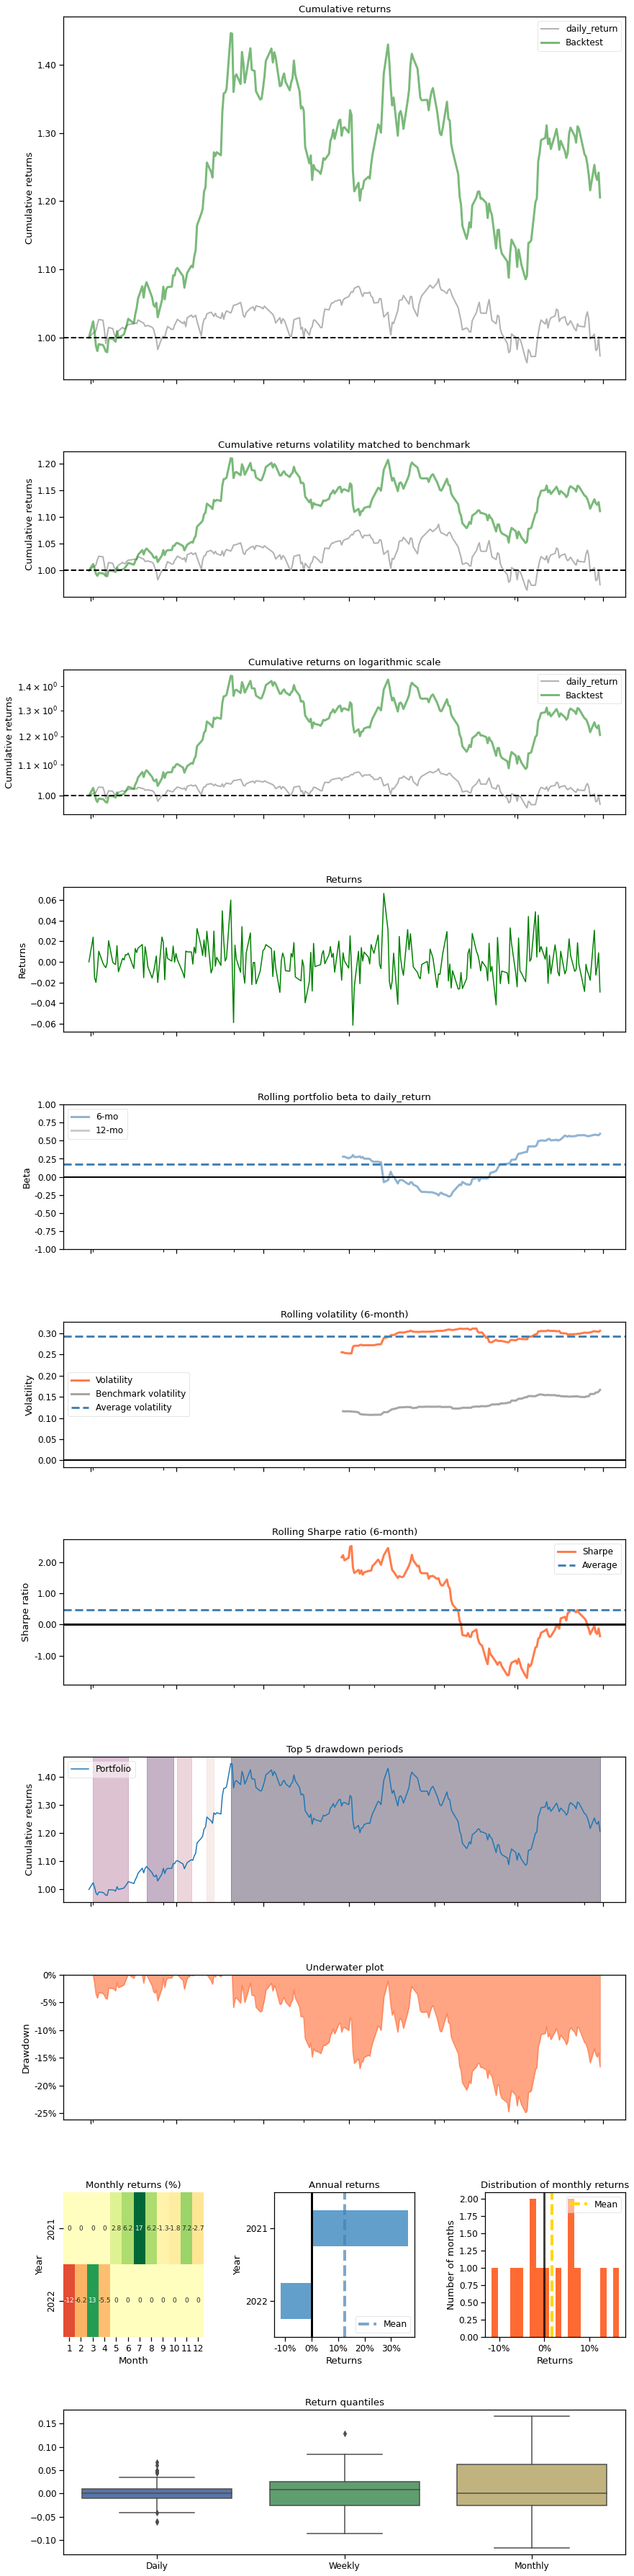

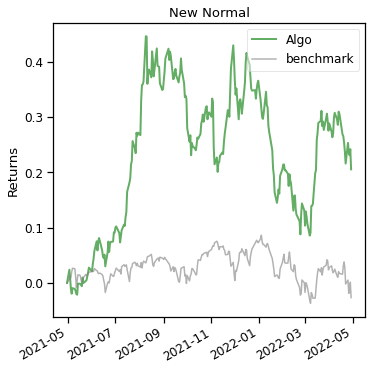

In [39]:
%matplotlib inline
exp7_strat, exp7_stats = check_portfolio(exp7_return)
graph_portfolio(exp7_strat, train_config["BASE_TICK"], train_config["TRAIN_TEST_SPLIT"], train_config["END_DATE"])

In [20]:
import empyrical as ep
cum_rets = ep.cum_returns(exp1_return["daily_return"], 1.0)

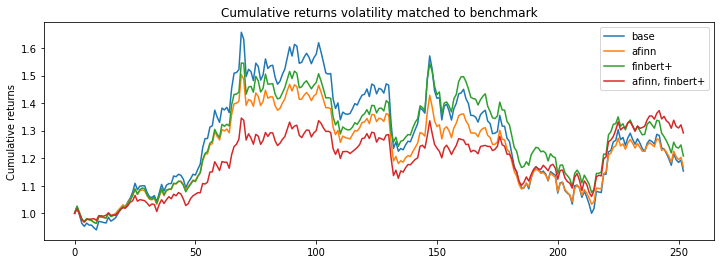

In [27]:
import matplotlib.pyplot as plt
dates = base_return.date
fig = plt.figure()
fig.set_size_inches(12, 4)
plt.plot(ep.cum_returns(base_return["daily_return"], 1.0),label='base')
#plt.plot(ep.cum_returns(exp1_return["daily_return"], 1.0),label='all')
plt.plot(ep.cum_returns(exp2_return["daily_return"], 1.0),label='afinn')
#plt.plot(ep.cum_returns(exp3_return["daily_return"], 1.0),label='finbert')
plt.plot(ep.cum_returns(exp4_return["daily_return"], 1.0),label='finbert+')
plt.plot(ep.cum_returns(exp5_return["daily_return"], 1.0),label='afinn, finbert+')
#plt.xticks(rotation=45)
plt.ylabel('Cumulative returns')
plt.title('Cumulative returns volatility matched to benchmark')
plt.legend()
plt.show()

In [29]:
np.corrcoef(exp1_return["daily_return"], exp2_return["daily_return"])

array([[1.        , 0.98221402],
       [0.98221402, 1.        ]])

In [31]:
nlp = pd.read_csv('./dataset/nlp.csv')
nlp.columns

Index(['Unnamed: 0', 'date', 'weighted_afinn', 'weighted_positive',
       'weighted_negative', 'weighted_neutral', 'tic'],
      dtype='object')

In [36]:
diff = pd.D

array([[1.      , 0.275713],
       [0.275713, 1.      ]])

In [33]:
np.corrcoef(nlp.weighted_negative, nlp.weighted_positive)

array([[ 1.        , -0.13498994],
       [-0.13498994,  1.        ]])